In [1]:
import numpy as np
from numpy.linalg import multi_dot
from numpy.linalg import qr
import numpy.linalg as npla
import scipy as sp
from scipy.linalg import block_diag, logm, eigvals
from multiprocessing import Pool
from functools import partial
import multiprocessing
from multiprocessing import set_start_method
from multiprocessing import get_context
import joblib
import time
import matplotlib.pyplot as plt
from scipy.linalg import lu

theta_crit = np.pi/4

In [4]:
def FullTransfer(strip_length,strip_width,theta): 
    sin = np.sin(theta)
    cos = np.cos(theta) 
    
    def FullStrip(sin,cos,strip_width):
        
        def TAS(sin,cos,strip_width):
        
            def TAMatrix(sin,cos, phi_one,phi_two,phi_three):
                matrix_one = np.array([[1,0],[0,np.exp(-1j*phi_three)]])
                matrix_two = np.array([[1,-sin],[-sin,1]])
                matrix_three = np.array([[np.exp(1j*phi_two),0],[0,np.exp(-1j*phi_one)]])

                return (1/cos)*multi_dot([matrix_one,matrix_two,matrix_three])

            Tslist = [ 
                TAMatrix(sin,cos,*(2*np.pi)*np.random.random_sample(3)) for i in range(strip_width)
            ]
            return block_diag(*Tslist)

        def TBS(sin,cos,strip_width):

            def TBMatrix(sin,cos, phi_one,phi_two,phi_three):   
                matrix_one = np.array([[np.exp(-1j*phi_three),0],[0,np.exp(1j*phi_one)]])
                matrix_two = np.array([[1,cos],[cos,1]])
                matrix_three = np.array([[-1,0],[0,np.exp(1j*phi_two)]])

                return (1/sin*multi_dot([matrix_one,matrix_two,matrix_three]))

            Tslist = [ 
                TBMatrix(sin,cos,*(2*np.pi)*np.random.random_sample(3)) for i in range(strip_width-1)
            ]
            extra = TBMatrix(sin,cos,*(2*np.pi)*np.random.random_sample(3))
            temp_mat = block_diag(extra[1,1],*Tslist,extra[0,0])    
            temp_mat[0,(2*strip_width)-1] = extra[1,0]
            temp_mat[(2*strip_width)-1,0] = extra[0,1]
            return temp_mat
    
        return np.matmul(TAS(sin,cos,strip_width),TBS(sin,cos,strip_width))

    
    Tone = FullStrip(sin,cos,strip_width)
    pone,lone,uone = lu(Tone)
    bigQ = np.matmul(pone,lone)
    rlog_one = np.log(np.absolute(uone.diagonal()))
    for i in range(int((strip_length-1)/10)):
        temp = multi_dot([FullStrip(sin,cos,strip_width) for i in range(8)])
        matrixb = np.matmul(temp,bigQ)
        p,l,u = lu(matrixb)
        bigQ = np.matmul(p,l)
        rlogs = np.log(np.absolute(u.diagonal()))
        rlog_one = np.add(rlogs,rlog_one)
    return rlog_one

In [5]:
start_time = time.time()
test = FullTransfer(100,32,np.pi/4)
print('%s seconds' %(time.time() - start_time))

0.27498412132263184 seconds


In [22]:
theta_crit = np.pi/4
strip_length = 1000
strip_width = 16
start_time = time.time()
theta_list = theta_list = np.linspace(np.pi/10,np.pi/2.1,15)

start_time = time.time()

partial_func = partial(FullTransfer,strip_length,strip_width)

p = get_context("fork").Pool()
final_array= p.map(partial_func, theta_list)

print("--- %s minutes---" % ((time.time() - start_time)/60))

--- 0.2964554190635681 minutes---


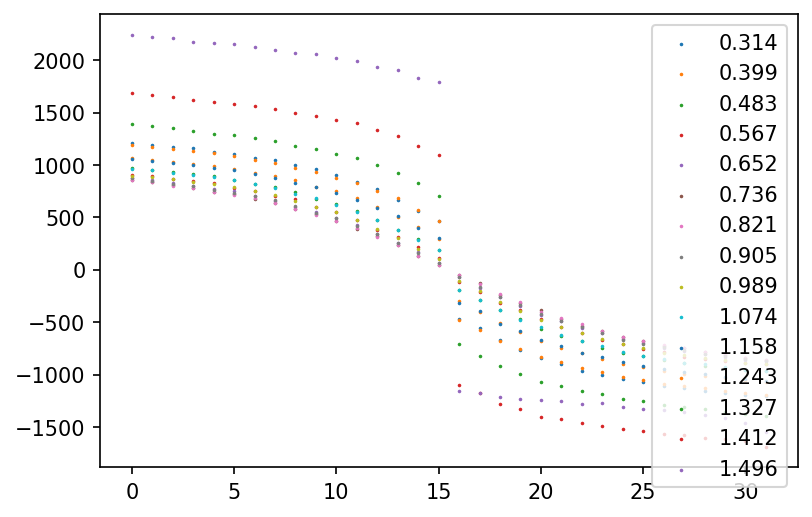

In [23]:
plt.figure(dpi = 150)
for n, i in enumerate(final_array):
    plt.scatter([i for i in range(2*strip_width)], i, s = 0.5, label = '%s' %round(theta_list[n],3))
plt.legend()

In [24]:
for i in final_array:
    print(sum(i))

-0.001531767134565598
-9.463402739129378e-05
1.6480099702675943e-06
-4.672472186939558e-07
1.6190912219826714e-06
1.1702303481797571e-06
-1.4540196389134508e-06
1.907691284941393e-07
-5.161672333997558e-07
6.058203666725603e-06
0.00015327865344261227
-0.000438009809158757
-0.15287398741497782
194.72130991010044
12043.271002052148


In [5]:
range_val = 15

theta_eigs = np.array([theta_crit for i in range(range_val)])
partial_func = partial(FullTransfer,500,32)
for i in range(range_val):
    start_time = time.time()
    with Pool() as p:
        p = get_context("fork").Pool()
        transfer_list = p.map(partial_func, theta_eigs)
        final_array = [transfer_list[i][31] for i in range(range_val)]
        joblib.dump(final_array, 'Gaussian_Eig_files/gaussian_eigs_len100_width32_%s.pkl'%(i))
    print("--- %s seconds--- run %s is done." % ((time.time() - start_time), i))

--- 9.487845182418823 seconds--- run 0 is done.
--- 9.414159059524536 seconds--- run 1 is done.
--- 9.300636053085327 seconds--- run 2 is done.
--- 9.214000940322876 seconds--- run 3 is done.
--- 9.232152700424194 seconds--- run 4 is done.
--- 9.199826002120972 seconds--- run 5 is done.
--- 9.230991840362549 seconds--- run 6 is done.
--- 9.3141610622406 seconds--- run 7 is done.
--- 9.456009864807129 seconds--- run 8 is done.
--- 9.40378999710083 seconds--- run 9 is done.
--- 9.408188104629517 seconds--- run 10 is done.
--- 9.284892082214355 seconds--- run 11 is done.
--- 9.30645203590393 seconds--- run 12 is done.
--- 9.282631158828735 seconds--- run 13 is done.
--- 9.33407211303711 seconds--- run 14 is done.


In [6]:
data_list = [joblib.load('Gaussian_Eig_files/gaussian_eigs_len100_width32_%s.pkl'%(i)) for i in range(range_val)]

In [7]:

combined_list = joblib.load('Gaussian_Eig_files/final_list.pkl')
for i in data_list:
    combined_list += i
print(len(combined_list))
joblib.dump(combined_list,'Gaussian_Eig_files/final_list.pkl')

3742


['Gaussian_Eig_files/final_list.pkl']

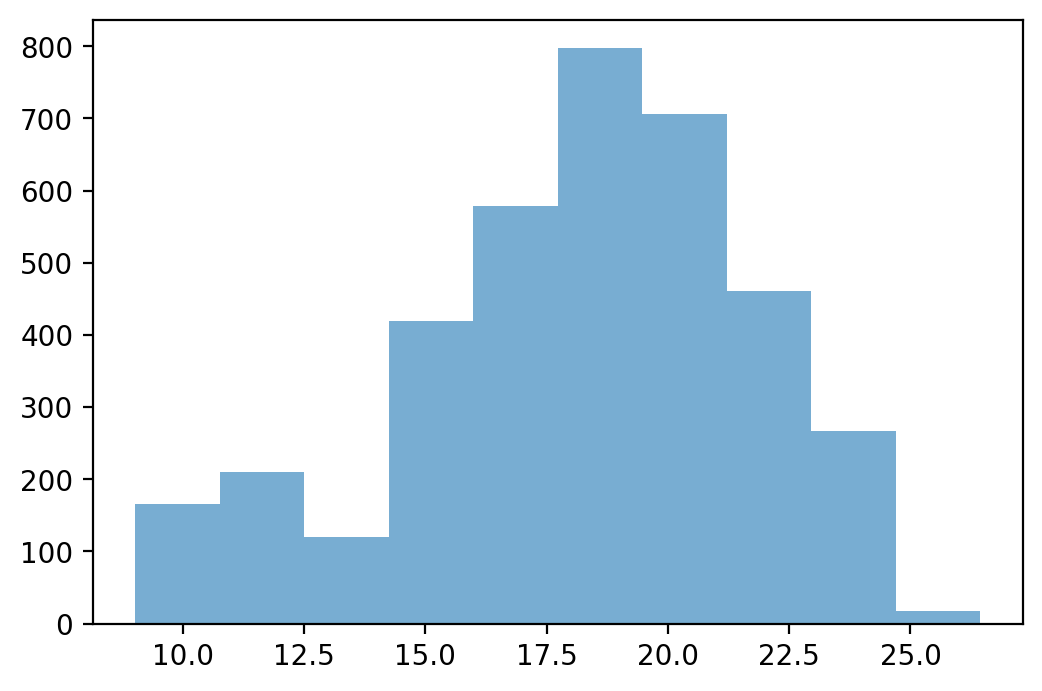

In [9]:
plt.figure(dpi = 200)
plt.hist(combined_list, bins = 10, alpha = 0.6)
plt.show()